# Getting Setup
This section goes through various steps to get setup for outlier detection. For more details see the ingesting ISIS control networks tutorial.

## Imports

In [1]:
# Required for autocnet imports
import os
os.environ['ISISROOT'] = '/usgs/cpkgs/anaconda3_linux/envs/isis4.2.0'

# Autocnet Imports
from autocnet.graph.network import NetworkCandidateGraph
from autocnet.graph.edge import NetworkEdge
from autocnet.io.db.model import Matches, Points
from autocnet.transformation.roi import Roi

# Helpful Python Modules
import matplotlib.pyplot as plt  #     plotting package
import numpy as np               #     numerical computing package

## Setting up the NetworkCandidateGraph

### Config

The config various settings that autocnet will use when connecting to other services. Primarily, the config is used to define:

- The database your NetworkCandidateGraph will use
- The redis queue and slurm settings for cluster based processing
- The spatial reference system for geometries such as image footprints

In [2]:
config_path = 'config.yml'

### Loading the control network
This cell will check if the database your config file points to already has a control network ingested in it. If it doesn't then it goes through the steps from the ingesting ISIS control networks tutorial.

In [3]:
data_directory = "/work/projects/control_network_metrics/tutorials/isis_ingestion"
lis_path = os.path.join(data_directory, "apollo_lronac_cubes.lis")
cnet_path = os.path.join(data_directory, "AS15_landingsite_apollolro_jig1.net")

ncg = NetworkCandidateGraph()
ncg.config_from_file(config_path)
ncg.from_database()
if len(ncg) == 0:
    print(f'Ingesting control network {cnet_path}.')
    ncg = NetworkCandidateGraph.from_cnet(cnet_path, lis_path, config_path)
else:
    print('Network already in database')

Network already in database


/work/users/jmapel/anaconda_local/envs/autocnet_local/lib/python3.7/site-packages/sqlalchemy/orm/relationships.py:1997: SAWarning: Setting backref / back_populates on relationship Overlay.points to refer to viewonly relationship Points.overlay should include sync_backref=False set on the Overlay.points relationship.  (this warning may be suppressed after 10 occurrences)
  (rel_b, rel_a, rel_b),
/work/users/jmapel/anaconda_local/envs/autocnet_local/lib/python3.7/site-packages/sqlalchemy/orm/relationships.py:1997: SAWarning: Setting backref / back_populates on relationship Points.overlay to refer to viewonly relationship Overlay.points should include sync_backref=False set on the Points.overlay relationship.  (this warning may be suppressed after 10 occurrences)
  (rel_b, rel_a, rel_b),


### Check network
Look at the graph of the network to ensure it isn't malformed. Each image in the network is represented by a node and overlapping images have an edge between their nodes. We will be doing pair-wise outlier detection, so we will check each edge in the network graph

<AxesSubplot:>

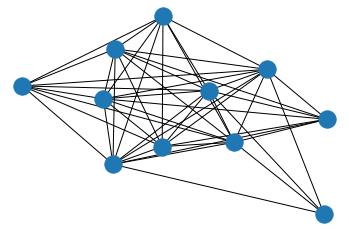

In [4]:
ncg.plot()

### Getting the pairwise image matches
The first process we need to do is collect all of the pairwise matches between images. Our control network currently contains control points and all of the measurements of them. We need to convert these multi-image relationships into all of the common points between each pair of images.

To do this, we're going to use Autocnet's apply function to run parallel processing on each edge of the NetworkCandidateGraph

In [5]:
?NetworkCandidateGraph.apply

#### SLURM parameters
These parameters will be used when creating SLURM jobs for cluster processing via the apply function. Depending on the complexity of the jobs you are running, you may want to change the walltime and arraychunk parameters.

In [6]:
walltime="00:30:00"
log_dir = '/scratch/jmapel/autocnet_tut/logs'
arraychunk=75
chunksize=16723

#### Convert control measures and points to image matches
This cell uses apply to run the network_to_matches function on each edge. It is very important that this function only get run once per edge or it will add duplicate matches. So, this cell also contains a check that skips the function if the database already has matches in it.

In [7]:
?NetworkEdge.network_to_matches

In [8]:
with ncg.session_scope() as session:
    num_matches = session.query(Matches).count()
if num_matches == 0:
    print("Loading matches table")
    njobs = ncg.apply('network_to_matches', 
                      on='edges',
                      # SLURM kwargs
                      walltime=walltime,
                      log_dir=os.path.join(log_dir, 'matches'),
                      arraychunk=arraychunk,
                      chunksize=chunksize)
else:
    print("Matches table already populated")

Loading matches table


### Looking at the matches
The pairwise image matches are stored on the edges of the graph and can be accessed via the networkX graph or the matches table in the database

In [9]:
for source, dest, edge in ncg.edges(data='data'):
    print(f'Edge ({source}, {dest}) has {len(edge.matches)} matches')

Edge (10, 6) has 440 matches
Edge (10, 3) has 4 matches
Edge (10, 4) has 4 matches
Edge (10, 2) has 4 matches
Edge (10, 11) has 39 matches
Edge (10, 8) has 477 matches
Edge (10, 5) has 4 matches
Edge (10, 7) has 54 matches
Edge (1, 3) has 178 matches
Edge (1, 4) has 82 matches
Edge (1, 2) has 197 matches
Edge (1, 5) has 19 matches
Edge (6, 3) has 4 matches
Edge (6, 4) has 4 matches
Edge (6, 2) has 4 matches
Edge (6, 11) has 38 matches
Edge (6, 8) has 419 matches
Edge (6, 5) has 4 matches
Edge (6, 7) has 46 matches
Edge (3, 9) has 3 matches
Edge (3, 4) has 271 matches
Edge (3, 2) has 274 matches
Edge (3, 11) has 5 matches
Edge (3, 8) has 4 matches
Edge (3, 5) has 181 matches
Edge (3, 7) has 2 matches
Edge (9, 4) has 3 matches
Edge (9, 2) has 3 matches
Edge (9, 11) has 239 matches
Edge (9, 8) has 42 matches
Edge (9, 5) has 3 matches
Edge (9, 7) has 213 matches
Edge (4, 2) has 166 matches
Edge (4, 11) has 5 matches
Edge (4, 8) has 4 matches
Edge (4, 5) has 199 matches
Edge (4, 7) has 2 ma

## Outlier Detection

### Reprojective Error
These two functions check for outliers by attempting to reproject measures between images. Any pair of measures that do not repoject to each other wth in a given tolerance are flagged.

In [ ]:
?NetworkEdge.compute_fundamental_matrix

In [ ]:
?NetworkEdge.compute_homography

These cells also demonstrate how to pass kwargs through apply. Any kwargs that are not specific to the apply function are passed on to the function being applied.

In [10]:
njobs = ncg.apply('compute_fundamental_matrix', 
                  on='edges',
                  # homography kwargs
                  method='mle',
                  reproj_threshold=5,
                  # SLURM kwargs
                  walltime=walltime,
                  log_dir=os.path.join(log_dir, 'fundamental'),
                  arraychunk=arraychunk,
                  chunksize=chunksize)

In [11]:
njobs = ncg.apply('compute_homography', 
                  on='edges',
                  # fundamental matrix kwargs
                  method='lmeds',
                  reproj_threshold=5,
                  # SLURM kwargs
                  walltime=walltime,
                  log_dir=os.path.join(log_dir, 'homography'),
                  arraychunk=arraychunk,
                  chunksize=chunksize)

You can check the queue_length property on the NetworkCandidateGraph object to see how many jobs are either waiting to be processed or in process. You can also use the squeue command on a command line or in your notebook to check what jobs slurm has.

In [14]:
ncg.queue_length

0

In [13]:
!squeue -u jmapel

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON) 
          17780111   longall jupyter-   jmapel  R    2:09:58      1 neb16 
        17796596_1  shortall AutoCNet   jmapel  R       0:03      1 neb14 
        17796596_2  shortall AutoCNet   jmapel  R       0:03      1 neb14 
        17796596_3  shortall AutoCNet   jmapel  R       0:03      1 neb14 
        17796596_4  shortall AutoCNet   jmapel  R       0:03      1 neb14 
        17796596_5  shortall AutoCNet   jmapel  R       0:03      1 neb14 
        17796596_6  shortall AutoCNet   jmapel  R       0:03      1 neb14 
        17796596_7  shortall AutoCNet   jmapel  R       0:03      1 neb14 
        17796596_8  shortall AutoCNet   jmapel  R       0:03      1 neb14 
        17796596_9  shortall AutoCNet   jmapel  R       0:03      1 neb14 
       17796596_10  shortall AutoCNet   jmapel  R       0:03      1 neb15 
       17796596_11  shortall AutoCNet   jmapel  R       0:03      1 neb15 
       1779659

### Looking at the results
The reprojective error checks add a property to each called masks. This is a Pandas dataframe that contains a column for each check that has been done on the edge. If the row for a match has a true in it, then that match passed the column's check. Conversely, if the row for a match has a false in it, then that match failsed the column's check. We can use some dataframe techniques to look at our results

In [15]:
for source, dest, edge in ncg.edges(data="data"):
    num_matches = len(edge.matches)
    # MLE requires at least 8 points so skip anything with too few
    if num_matches < 8:
        continue
    print(f'edge ({source}, {dest})')
    print('num matches:', num_matches)
    print('passed homography:', sum(edge.masks['homography']))
    print('passed fundamental:', sum(edge.masks['fundamental']))
    print('too few matches to compute fundamental matrix')
    print('')

edge (10, 6)
num matches: 440
passed homography: 440
passed fundamental: 426
too few matches to compute fundamental matrix

edge (10, 11)
num matches: 39
passed homography: 30
passed fundamental: 38
too few matches to compute fundamental matrix

edge (10, 8)
num matches: 477
passed homography: 369
passed fundamental: 447
too few matches to compute fundamental matrix

edge (10, 7)
num matches: 54
passed homography: 45
passed fundamental: 54
too few matches to compute fundamental matrix

edge (1, 3)
num matches: 178
passed homography: 138
passed fundamental: 91
too few matches to compute fundamental matrix

edge (1, 4)
num matches: 82
passed homography: 61
passed fundamental: 52
too few matches to compute fundamental matrix

edge (1, 2)
num matches: 197
passed homography: 152
passed fundamental: 134
too few matches to compute fundamental matrix

edge (1, 5)
num matches: 19
passed homography: 17
passed fundamental: 16
too few matches to compute fundamental matrix

edge (6, 11)
num matches

## Digging in on edge (9, 7)
Edge (9, 7) has a lot of matches but many failures; let's take a closer look at it.

In [16]:
edge_9_7 = ncg.edges[(9, 7)]['data']
image_9 = ncg.nodes[9]
image_7 = ncg.nodes[7]
print(edge_9_7)
print(image_9)
print(image_7)


        Source Image Index: 7
        Destination Image Index: 9
        Available Masks:           fundamental  homography
match_id                         
1171             True       False
1172             True       False
1173             True       False
1174             True       False
1175             True       False
...               ...         ...
1455             True        True
1457             True        True
1458             True        True
1460             True        True
1462             True       False

[213 rows x 2 columns]
        
{'data': 
        NodeID: 9
        Image Name: /work/projects/control_network_metrics/tutorials/isis_ingestion/M102135625RE.lev1_8b.cub
        Image PATH: /work/projects/control_network_metrics/tutorials/isis_ingestion/M102135625RE.lev1_8b.cub
        Number Keypoints: 0
        Available Masks : Empty DataFrame
Columns: []
Index: []
        Type: <class 'autocnet.graph.node.NetworkNode'>
        }
{'data': 
        NodeID: 7
  

### Looking at the matches that failed outlier detection
We can use the masks dataframe to index the matches dataframe on our edge and see the matches that failed each check

In [17]:
failed_fundamental = edge_9_7.matches.loc[(~edge_9_7.masks[['fundamental']]).all(axis=1)]
failed_fundamental

,geom,point_id,source_measure_id,destin_measure_id,source,source_idx,destination,destination_idx,lat,lon,...,source_apriori_x,source_apriori_y,destination_x,destination_y,destination_apriori_x,destination_apriori_y,shift_x,shift_y,original_destination_x,original_destination_y
id,,,,,,,,,,,,,,,,,,,,,
1178,None,788,2324,2325,7,0,9,0,None,None,...,2231.12,16213.7,180.316,16595.5,204.205,16599.5,None,None,None,None
1228,None,1269,3678,3677,7,0,9,0,None,None,...,3082.24,6807.21,1001.12,7160.22,978.351,7163.4,None,None,None,None
1230,None,1271,3684,3683,7,0,9,0,None,None,...,3908.22,6813.23,1773.38,7180.67,1797.61,7184.37,None,None,None,None
1214,None,1243,3610,3609,7,0,9,0,None,None,...,3983.41,1699.58,1877.61,2095.96,1840.91,2099.48,None,None,None,None
1222,None,1261,3653,3652,7,0,9,0,None,None,...,2674.81,5831.07,493.5,6213.5,-0.5,-0.5,None,None,None,None
1223,None,1262,3655,3654,7,0,9,0,None,None,...,3078.79,5826.54,893.047,6201.25,918.537,6205.46,None,None,None,None
1238,None,1283,3716,3715,7,0,9,0,None,None,...,2557.44,8894.67,398.233,9273.58,424.971,9277.79,None,None,None,None
1246,None,1296,3750,3749,7,0,9,0,None,None,...,3361.97,10921,1318.89,11293.3,1356.33,11296.8,None,None,None,None
1247,None,1297,3753,3752,7,0,9,0,None,None,...,4664.18,10913.2,2828.5,11267.7,2791.51,11270.5,None,None,None,None


In [18]:
failed_homography = edge_9_7.matches.loc[(~edge_9_7.masks[['homography']]).all(axis=1)]
failed_homography

,geom,point_id,source_measure_id,destin_measure_id,source,source_idx,destination,destination_idx,lat,lon,...,source_apriori_x,source_apriori_y,destination_x,destination_y,destination_apriori_x,destination_apriori_y,shift_x,shift_y,original_destination_x,original_destination_y
id,,,,,,,,,,,,,,,,,,,,,
1177,None,787,2321,2322,7,0,9,0,None,None,...,2193.72,15099.1,124.431,15480.9,148.703,15485.1,None,None,None,None
1180,None,790,2331,2332,7,0,9,0,None,None,...,2058.33,21232.2,76.913,21614.3,101.831,21618.5,None,None,None,None
1181,None,791,2335,2336,7,0,9,0,None,None,...,2055.99,22259.5,90.9603,22641.3,115.847,22645.5,None,None,None,None
1182,None,792,2338,2339,7,0,9,0,None,None,...,2077.71,23322.8,233.419,23718.5,208.588,23721.5,None,None,None,None
1358,None,1416,4073,4072,7,0,9,0,None,None,...,4388.95,37514.9,3240.27,37842,3225.51,37843.1,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1288,None,1354,3901,3900,7,0,9,0,None,None,...,4633.26,20103.5,2761.5,20468.5,-0.5,-0.5,None,None,None,None
1289,None,1356,3906,3905,7,0,9,0,None,None,...,2449.74,21087.8,490.169,21466.9,514.354,21471,None,None,None,None
1290,None,1357,3909,3908,7,0,9,0,None,None,...,2893.79,21162.4,958.412,21537.6,983.276,21541.8,None,None,None,None


We can even use some techniques to see the matches that failed both checks

In [19]:
failed_both = edge_9_7.matches.loc[(~edge_9_7.masks[['fundamental', 'homography']]).all(axis=1)]
failed_both

,geom,point_id,source_measure_id,destin_measure_id,source,source_idx,destination,destination_idx,lat,lon,...,source_apriori_x,source_apriori_y,destination_x,destination_y,destination_apriori_x,destination_apriori_y,shift_x,shift_y,original_destination_x,original_destination_y
id,,,,,,,,,,,,,,,,,,,,,
1178,None,788,2324,2325,7,0,9,0,None,None,...,2231.12,16213.7,180.316,16595.5,204.205,16599.5,None,None,None,None
1228,None,1269,3678,3677,7,0,9,0,None,None,...,3082.24,6807.21,1001.12,7160.22,978.351,7163.4,None,None,None,None
1230,None,1271,3684,3683,7,0,9,0,None,None,...,3908.22,6813.23,1773.38,7180.67,1797.61,7184.37,None,None,None,None
1214,None,1243,3610,3609,7,0,9,0,None,None,...,3983.41,1699.58,1877.61,2095.96,1840.91,2099.48,None,None,None,None
1222,None,1261,3653,3652,7,0,9,0,None,None,...,2674.81,5831.07,493.5,6213.5,-0.5,-0.5,None,None,None,None
1223,None,1262,3655,3654,7,0,9,0,None,None,...,3078.79,5826.54,893.047,6201.25,918.537,6205.46,None,None,None,None
1264,None,1328,3829,3828,7,0,9,0,None,None,...,4237.17,16023.8,2321.67,16425.3,2309.89,16428.2,None,None,None,None
1267,None,1333,3841,3843,7,0,9,0,None,None,...,3323.35,17014,1364.5,17390.5,-0.5,-0.5,None,None,None,None


### Viewing individual matches
Let's take a closer look at the matches that failed both checks. We're going to use the Roi (Region of Interest) objects in Autocnet that allow you to look at a small portion of an image.

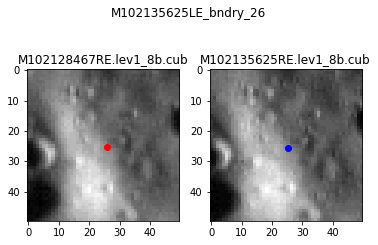

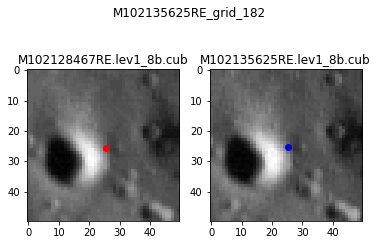

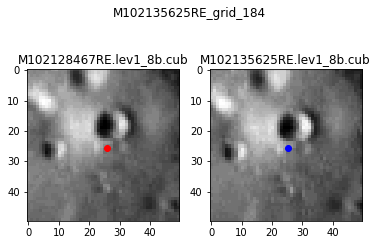

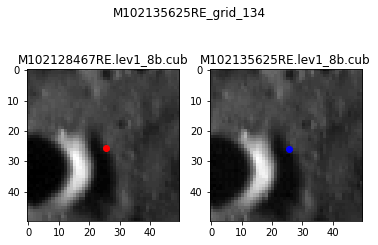

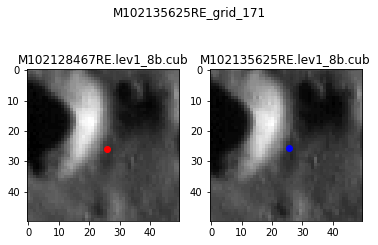

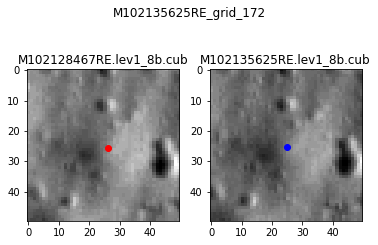

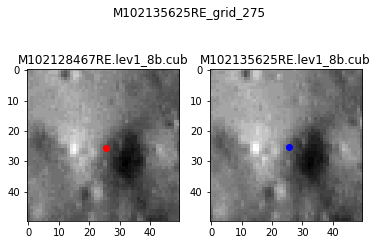

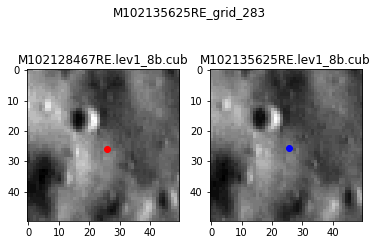

In [20]:
roi_size = 25
for idx, match in failed_both.iterrows():
    with ncg.session_scope() as session:
        point_name = session.query(Points).filter(Points.id == match["point_id"]).first().identifier

    source_image = ncg.nodes[match['source']]['data']
    dest_image = ncg.nodes[match['destination']]['data']
    source_roi = Roi(source_image.geodata, match['source_x'], match['source_y'], size_x=roi_size, size_y=roi_size)
    dest_roi = Roi(dest_image.geodata, match['destination_x'], match['destination_y'], size_x=roi_size, size_y=roi_size)

    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.suptitle(point_name)
    ax1.imshow(source_roi.array, cmap='gray')
    ax1.plot(source_roi.center[0] + source_roi.axr, source_roi.center[1] + source_roi.ayr, 'ro')
    ax1.title.set_text(os.path.split(source_image['image_name'])[-1])
    ax2.imshow(dest_roi.array, cmap='gray')
    ax2.plot(dest_roi.center[0] + dest_roi.axr, dest_roi.center[1] + dest_roi.ayr, 'bo')
    ax2.title.set_text(os.path.split(dest_image['image_name'])[-1])
    fig.show()